DAY 1: Data Processing and Feature Engineering

In [ ]:
import pandas as pd
import numpy as np


train = pd.read_csv("/content/train.csv", parse_dates=['date'])
test = pd.read_csv("/content/test.csv", parse_dates=['date'])
stores = pd.read_csv("/content/stores.csv")
oil = pd.read_csv("/content/oil.csv", parse_dates=['date'])
holidays = pd.read_csv("/content/holidays_events.csv", parse_dates=['date'])

In [1]:
oil['dcoilwtico'] = oil['dcoilwtico'].interpolate(method='linear')

train_merged = train.merge(stores, on='store_nbr', how='left')

train_merged = train_merged.merge(oil, on='date', how='left')

#(merge with duplicates handled)
holidays['is_holiday'] = 1
holidays_simple = holidays[['date', 'is_holiday']].drop_duplicates()
train_merged = train_merged.merge(holidays_simple, on='date', how='left')
train_merged['is_holiday'] = train_merged['is_holiday'].fillna(0)

train_merged['earthquake'] = (train_merged['date'] == '2016-04-16').astype(int)

train_merged['day'] = train_merged['date'].dt.day
train_merged['is_payday'] = train_merged['day'].isin([15, 31]).astype(int)

train_merged['year'] = train_merged['date'].dt.year
train_merged['month'] = train_merged['date'].dt.month
train_merged['week'] = train_merged['date'].dt.isocalendar().week
train_merged['weekday'] = train_merged['date'].dt.weekday

train_merged.sort_values(by=['store_nbr', 'family', 'date'], inplace=True)

train_merged['sales_lag_1'] = train_merged.groupby(['store_nbr', 'family'])['sales'].shift(1)
train_merged['sales_lag_7'] = train_merged.groupby(['store_nbr', 'family'])['sales'].shift(7)
train_merged['rolling_mean_7'] = train_merged.groupby(['store_nbr', 'family'])['sales'].shift(1).rolling(7).mean()
train_merged['rolling_std_7'] = train_merged.groupby(['store_nbr', 'family'])['sales'].shift(1).rolling(7).std()

train_final = train_merged.dropna()

train_final.head()


,id,date,store_nbr,family,sales,onpromotion,city,state,type,cluster,...,day,is_payday,year,month,week,weekday,sales_lag_1,sales_lag_7,rolling_mean_7,rolling_std_7
12474,12474,2013-01-08,1,AUTOMOTIVE,2.0,0.0,Quito,Pichincha,D,13,...,8,0,2013,1,2,1,0.0,0.0,2.142857,1.772811
14256,14256,2013-01-09,1,AUTOMOTIVE,2.0,0.0,Quito,Pichincha,D,13,...,9,0,2013,1,2,2,2.0,2.0,2.428571,1.511858
16038,16038,2013-01-10,1,AUTOMOTIVE,2.0,0.0,Quito,Pichincha,D,13,...,10,0,2013,1,2,3,2.0,3.0,2.428571,1.511858
17820,17820,2013-01-11,1,AUTOMOTIVE,3.0,0.0,Quito,Pichincha,D,13,...,11,0,2013,1,2,4,2.0,3.0,2.285714,1.496026
23166,23166,2013-01-14,1,AUTOMOTIVE,2.0,0.0,Quito,Pichincha,D,13,...,14,0,2013,1,3,0,2.0,0.0,1.857143,0.899735


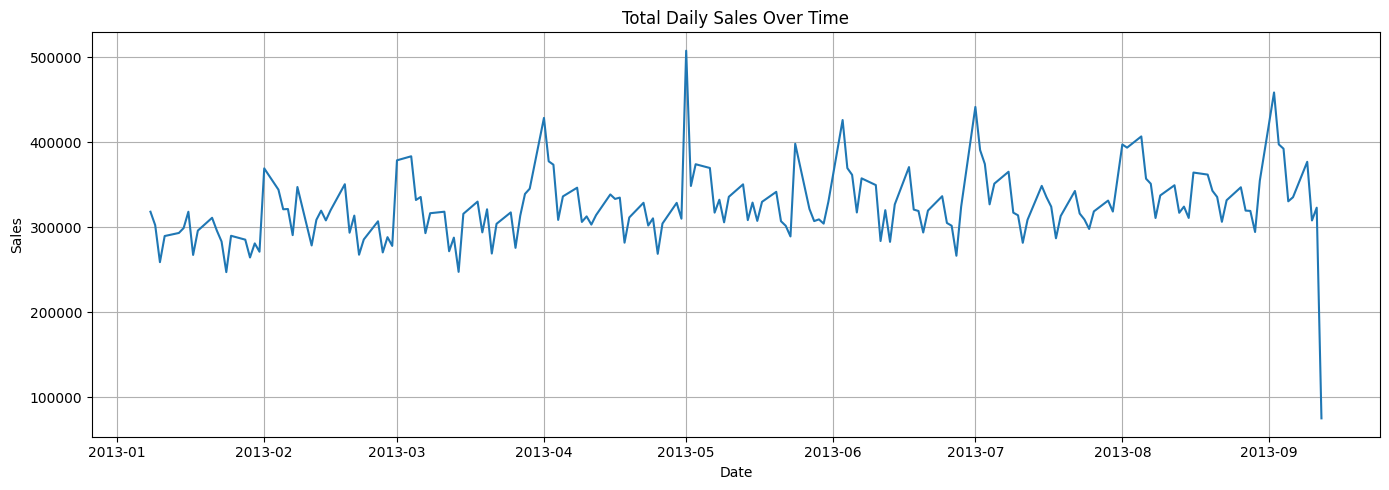

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

daily_sales = train_final.groupby('date')['sales'].sum().reset_index()

# Plot overall sales trend
plt.figure(figsize=(14, 5))
sns.lineplot(data=daily_sales, x='date', y='sales')
plt.title("Total Daily Sales Over Time")
plt.xlabel("Date")
plt.ylabel("Sales")
plt.grid(True)
plt.tight_layout()
plt.show()

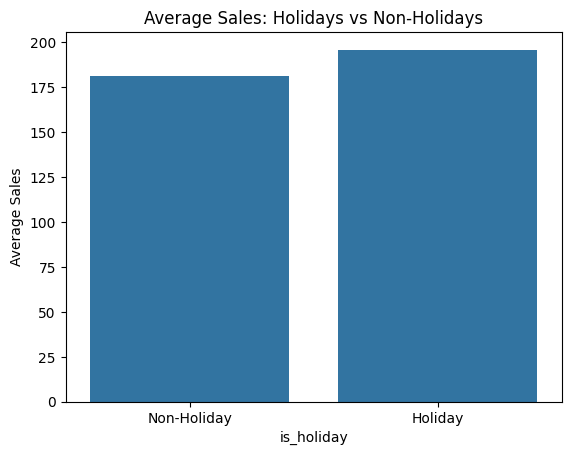

In [4]:
holiday_sales = train_final.groupby(['is_holiday'])['sales'].mean().reset_index()

sns.barplot(data=holiday_sales, x='is_holiday', y='sales')
plt.title("Average Sales: Holidays vs Non-Holidays")
plt.xticks([0, 1], ['Non-Holiday', 'Holiday'])
plt.ylabel("Average Sales")
plt.show()

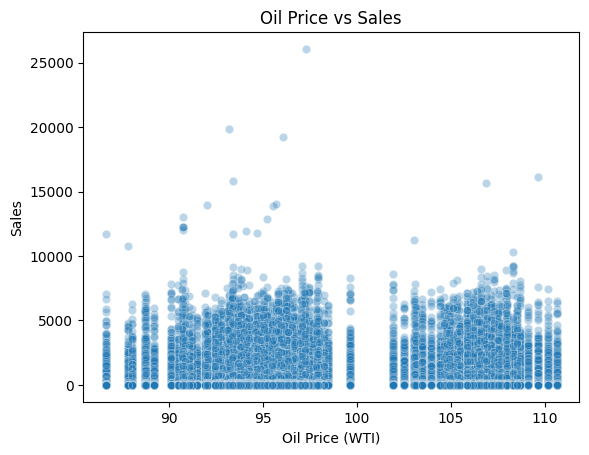

In [5]:
sns.scatterplot(data=train_final, x='dcoilwtico', y='sales', alpha=0.3)
plt.title("Oil Price vs Sales")
plt.xlabel("Oil Price (WTI)")
plt.ylabel("Sales")
plt.show()

<ipython-input-6-51cacda42063>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=monthly_sales, x='month', y='sales', palette='viridis')


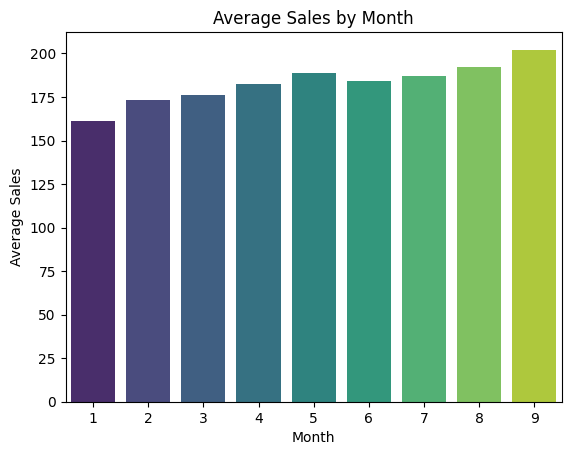

In [6]:
monthly_sales = train_final.groupby('month')['sales'].mean().reset_index()

sns.barplot(data=monthly_sales, x='month', y='sales', palette='viridis')
plt.title("Average Sales by Month")
plt.xlabel("Month")
plt.ylabel("Average Sales")
plt.show()

In [7]:
train_final.to_csv("cleaned_sales_data.csv", index=False)

In [9]:
#using XGBoost for forecasting
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, r2_score
from xgboost import XGBRegressor

features = [
    'store_nbr', 'family', 'onpromotion', 'cluster', 'dcoilwtico',
    'is_holiday', 'earthquake', 'is_payday',
    'year', 'month', 'week', 'weekday',
    'sales_lag_1', 'sales_lag_7', 'rolling_mean_7', 'rolling_std_7'
]

train_final['family'] = train_final['family'].astype('category').cat.codes

model_data = train_final.dropna(subset=features + ['sales'])

X = model_data[features]
y = model_data['sales']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

xgb_model = XGBRegressor(n_estimators=100, max_depth=6, learning_rate=0.1, random_state=42)
xgb_model.fit(X_train, y_train)

# Predictions
y_pred = xgb_model.predict(X_test)

rmse = mean_squared_error(y_test, y_pred)
mape = mean_absolute_percentage_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

rmse, mape, r2


<ipython-input-9-eae28b13f4e6>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_final['family'] = train_final['family'].astype('category').cat.codes


(95204.6301475565, 1511344389760867.5, 0.8739278670959276)

 Day 2: Forecasting Model with XGBoost

In [10]:
features = [
    'store_nbr', 'family', 'onpromotion', 'cluster', 'dcoilwtico',
    'is_holiday', 'earthquake', 'is_payday',
    'year', 'month', 'week', 'weekday',
    'sales_lag_1', 'sales_lag_7', 'rolling_mean_7', 'rolling_std_7'
]
train_final['family'] = train_final['family'].astype('category').cat.codes

model_data = train_final.dropna(subset=features + ['sales'])

X = model_data[features]
y = model_data['sales']


<ipython-input-10-1b57dff49e37>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_final['family'] = train_final['family'].astype('category').cat.codes


In [11]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

In [12]:
from xgboost import XGBRegressor

xgb_model = XGBRegressor(
    n_estimators=100,
    max_depth=6,
    learning_rate=0.1,
    random_state=42
)

# Fit
xgb_model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=6, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

In [13]:
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, r2_score

# Predict
y_pred = xgb_model.predict(X_test)

rmse = mean_squared_error(y_test, y_pred)
mape = mean_absolute_percentage_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"📉 RMSE: {rmse:.2f}")
print(f"📉 MAPE: {mape:.2%}")
print(f"📈 R-squared: {r2:.4f}")

📉 RMSE: 95204.63
📉 MAPE: 151134438976086752.00%
📈 R-squared: 0.8739


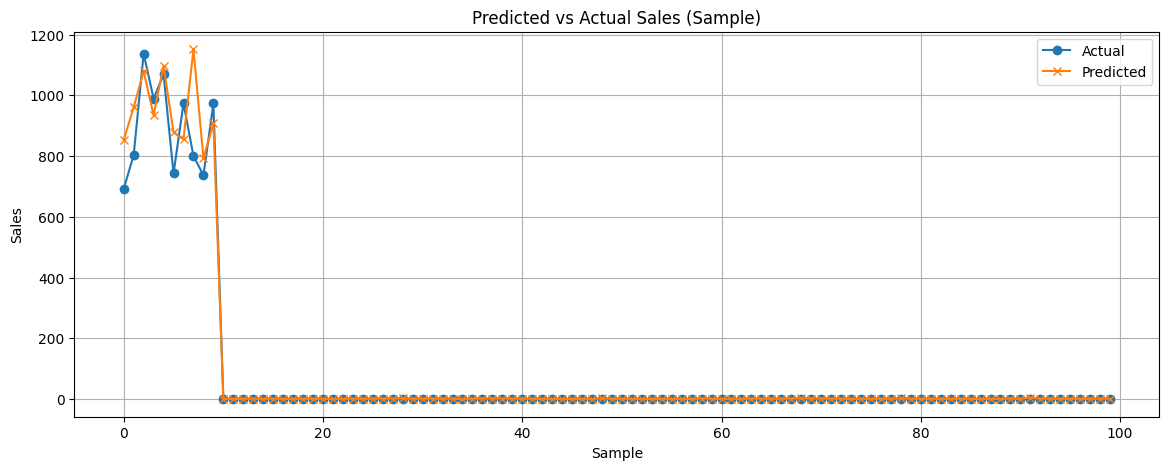

In [22]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 5))
plt.plot(y_test.values[:100], label='Actual', marker='o')
plt.plot(y_pred[:100], label='Predicted', marker='x')
plt.title("Predicted vs Actual Sales (Sample)")
plt.xlabel("Sample")
plt.ylabel("Sales")
plt.legend()
plt.grid(True)
plt.show()

Day 2: Model Selection, Forecasting & Evaluation
We will implement:

Baseline Model – Naïve forecast

ARIMA – Classical time series model

Random Forest Regressor

XGBoost – Already implemented

LSTM – Deep learning model

Model Evaluation (RMSE, MAPE, R²)
Visual Comparison,Feature Importance,Business Insights

In [15]:
#navie bias
y_pred_naive = X_test['sales_lag_1']
rmse_naive = mean_squared_error(y_test, y_pred_naive)
mape_naive = mean_absolute_percentage_error(y_test, y_pred_naive)
r2_naive = r2_score(y_test, y_pred_naive)

print(f"Naive Model → RMSE: {rmse_naive:.2f}, MAPE: {mape_naive:.2%}, R²: {r2_naive:.4f}")


Naive Model → RMSE: 168561.97, MAPE: 26323671297815836.00%, R²: 0.7768


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  self._init_dates(dates, freq)


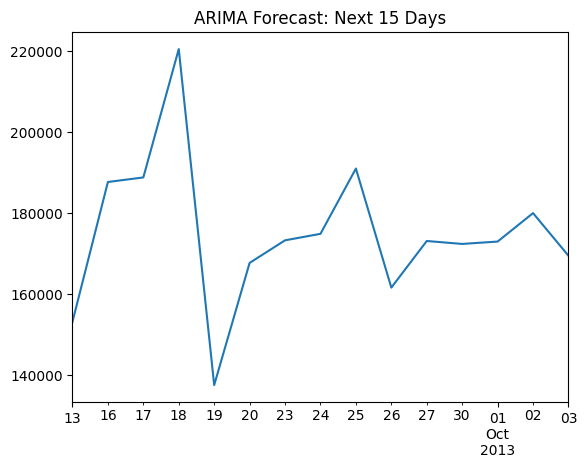

In [16]:
#arima
from statsmodels.tsa.arima.model import ARIMA

daily_sales = train_final.groupby('date')['sales'].sum()

arima_model = ARIMA(daily_sales, order=(5, 1, 0))
arima_result = arima_model.fit()

forecast_arima = arima_result.forecast(steps=15)

forecast_arima.plot(title='ARIMA Forecast: Next 15 Days')
plt.show()


In [17]:
#randomforest
from sklearn.ensemble import RandomForestRegressor

rf_model = RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42)
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)

print("Random Forest →",
      f"RMSE: {mean_squared_error(y_test, y_pred_rf):.2f}, ",
      f"MAPE: {mean_absolute_percentage_error(y_test, y_pred_rf):.2%}, ",
      f"R²: {r2_score(y_test, y_pred_rf):.4f}")


Random Forest → RMSE: 62666.35,  MAPE: 89819012861373200.00%,  R²: 0.9170


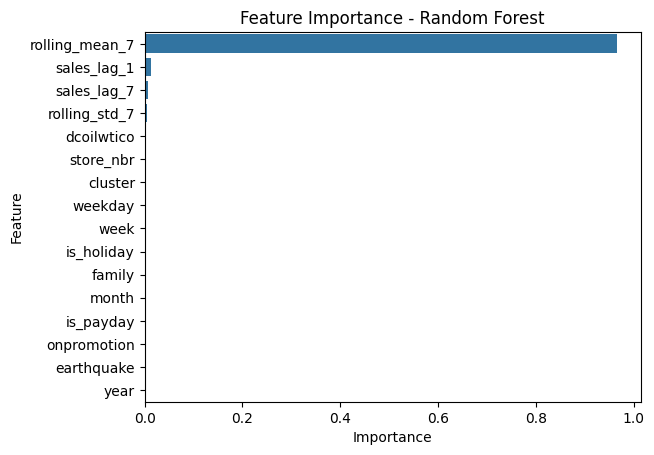

In [18]:
importances = rf_model.feature_importances_
feature_names = X_train.columns

feat_imp_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
feat_imp_df = feat_imp_df.sort_values(by='Importance', ascending=False)

sns.barplot(data=feat_imp_df, x='Importance', y='Feature')
plt.title("Feature Importance - Random Forest")
plt.show()


In [21]:
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

scaler = MinMaxScaler()
scaled_sales = scaler.fit_transform(y.values.reshape(-1, 1))

def create_sequences(data, time_steps=10):
    Xs, ys = [], []
    for i in range(len(data) - time_steps):
        Xs.append(data[i:i+time_steps])
        ys.append(data[i+time_steps])
    return np.array(Xs), np.array(ys)

X_lstm, y_lstm = create_sequences(scaled_sales, 15)
X_train_lstm, X_test_lstm = X_lstm[:-300], X_lstm[-300:]
y_train_lstm, y_test_lstm = y_lstm[:-300], y_lstm[-300:]

# LSTM model
model = Sequential([
    LSTM(64, input_shape=(X_train_lstm.shape[1], 1)),
    Dense(1)
])

model.compile(optimizer='adam', loss='mse')
model.fit(X_train_lstm, y_train_lstm, epochs=5, batch_size=32)

# Predict
y_pred_lstm = model.predict(X_test_lstm)
y_pred_lstm_inv = scaler.inverse_transform(y_pred_lstm)

# Evaluate
print("LSTM →",
      f"RMSE: {mean_squared_error(y_test[-300:], y_pred_lstm_inv):.2f}")


Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


9865/9865 ━━━━━━━━━━━━━━━━━━━━ 93s 9ms/step - loss: 5.0712e-05
Epoch 2/5
9865/9865 ━━━━━━━━━━━━━━━━━━━━ 88s 9ms/step - loss: 4.0477e-05
Epoch 3/5
9865/9865 ━━━━━━━━━━━━━━━━━━━━ 151s 10ms/step - loss: 4.2767e-05
Epoch 4/5
9865/9865 ━━━━━━━━━━━━━━━━━━━━ 147s 10ms/step - loss: 4.3787e-05
Epoch 5/5
9865/9865 ━━━━━━━━━━━━━━━━━━━━ 92s 9ms/step - loss: 3.9676e-05
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
LSTM → RMSE: 73.22
